# Bitcoin Price Prediction using Deep Learning Techniques

This notebook holds all experiments for the paper [insert name here](insert-link-here)

---

### Authors
 - Author1
 - Author2
 - Author3
    
### Date Created: 2024-04-22
### Date Last Modified: 2024-04-24

In [1]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [2]:
# We intend to shut down all warnings, and non-essential information in this notebook from TensorFlow
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import make_column_transformer

from typing import List, Tuple, Dict

In [4]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [5]:
# Checking the version of TensorFlow
print(tf.__version__)

2.15.0


## Dataset Preparation

In [6]:
dataframe = pd.read_csv('data/BTC-USD.csv', parse_dates=['Date'], index_col='Date')
dataframe.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [7]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3505 entries, 2014-09-17 to 2024-04-21
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3505 non-null   float64
 1   High       3505 non-null   float64
 2   Low        3505 non-null   float64
 3   Close      3505 non-null   float64
 4   Adj Close  3505 non-null   float64
 5   Volume     3505 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 191.7 KB


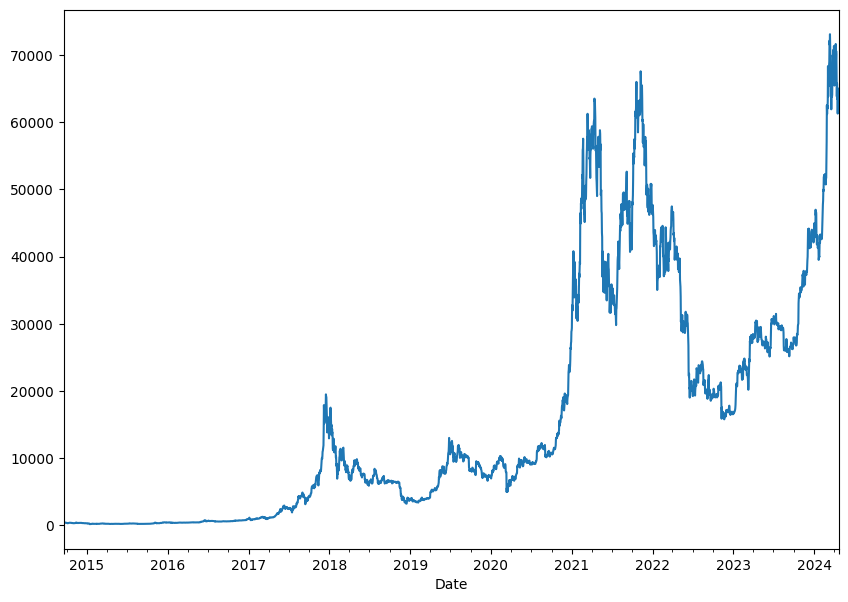

In [8]:
dataframe['Close'].plot(figsize=(10, 7));

In [9]:
# `btcc_prices` denotes the closing prices of BTC-USD.
btcc_prices = pd.DataFrame(dataframe["Close"].values, columns=["Price"], index=dataframe.index)
btcc_prices.head()

,Price
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014


In [10]:
prices = btcc_prices['Price'].to_numpy()
prices

array([  457.334015,   424.440002,   394.79599 , ..., 63843.570313,
       64994.441406, 64773.386719])

In [11]:
# Normalizing the data
scaler = MinMaxScaler()

prices_normal = scaler.fit_transform(prices.reshape(-1, 1))
prices_normal

array([[0.00383005],
       [0.00337886],
       [0.00297225],
       ...,
       [0.87326138],
       [0.88904719],
       [0.88601512]])

In [12]:
# Create a plotting function
def plot_time_series(timestamps: List, values: List, format="-", start=0, end=None, title=None,
                     yLabel='BTC USD Close') -> None:
    """
    Plots a series of timestamps against values.

    Parameters
    ----------
    timestamps : list
        list of timestamp values
    values : list
        list of values across time
    format : str
        style of plot, default "."
    start : int
        starting index of the plot, ``start < len(timestamps)``
    end : int
        ending index of the plot, ``end < len(timestamps)``
    title : str
        label to show on plot of values
    """

    plt.plot(timestamps[start:end], values[start:end], format, label=title)
    plt.xlabel('Time')
    plt.ylabel(yLabel)
    if title:
        plt.legend(fontsize=14)
    plt.grid(True)


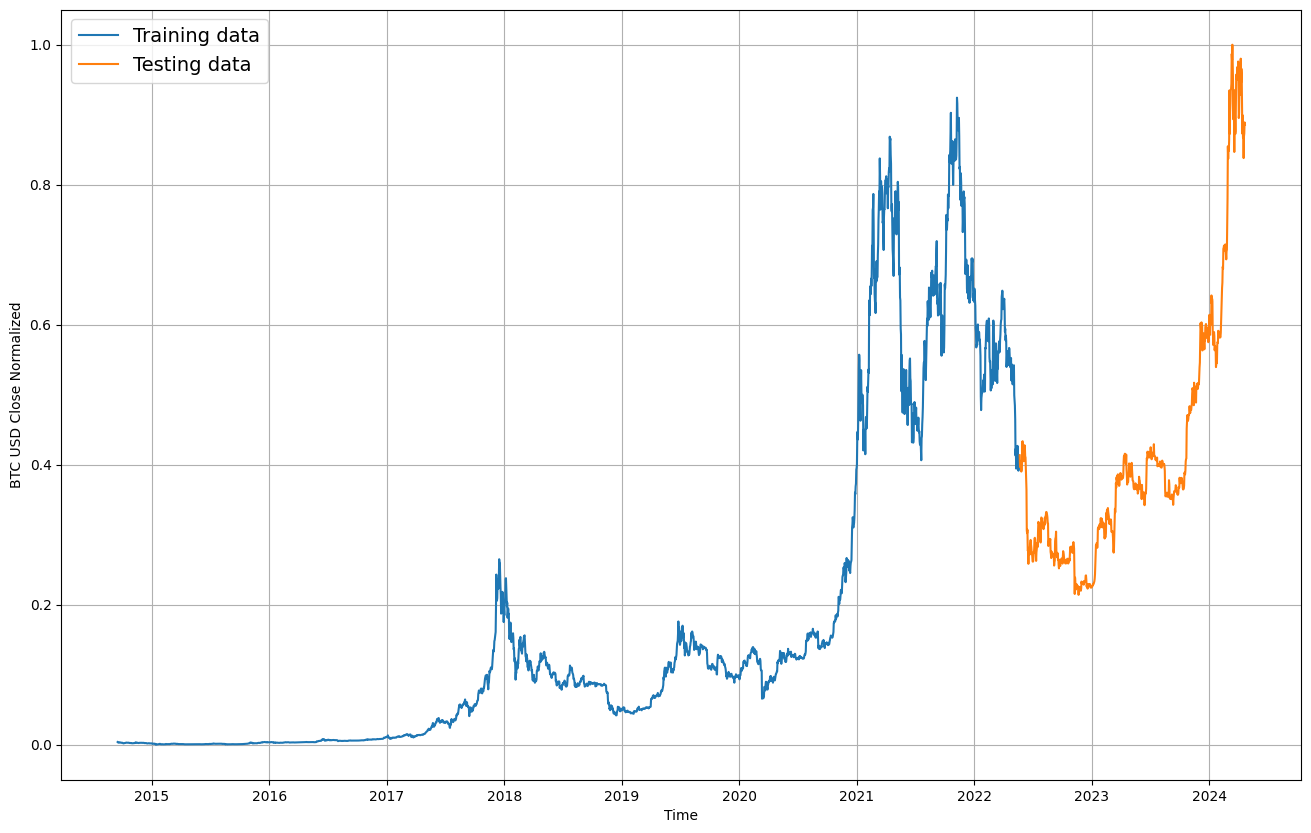

In [13]:
timestamps = btcc_prices.index.to_numpy()
training_data_len = int(.8 * len(btcc_prices))
test_data_len = len(btcc_prices) - training_data_len

plt.figure(figsize=(16, 10))
plot_time_series(timestamps=timestamps[:training_data_len], values=prices_normal[:training_data_len],
                 title="Training data")
plot_time_series(timestamps=timestamps[-test_data_len:], values=prices_normal[-test_data_len:], title="Testing data",
                 yLabel='BTC USD Close Normalized')

## Evaluation Metrics

In [14]:
def evaluate_pred(y_true: List, y_pred: List) -> Dict:
    """
    Performs various evaluation comparison functions on y_true labels and y_pred labels.

    Parameters
    ----------
    y_true : List
        true values
    y_pred : List
        predicted values

    Returns
    -------
    errors : dict
        dictionary containing the evaluation metrics, each metric is defined as a key-value pair where the key is the acronym for the metric in lowercase English.
    """
    # Make sure float32 datatype (for metric calculations)
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Calculate various evaluation metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)

    if mae.ndim > 0:
        mae = tf.reduce_mean(mae)
        mse = tf.reduce_mean(mse)
        rmse = tf.reduce_mean(rmse)
        mape = tf.reduce_mean(mape)

    metric_results = {
        "mae": mae.numpy(),
        "mse": mse.numpy(),
        "rmse": rmse.numpy(),
        "mape": mape.numpy(),
    }
    return metric_results

## Create Windows

In [15]:
WINDOW_SIZE = 7
HORIZON = 1

In [16]:
def get_labelled_windows(x: List, horizon=HORIZON) -> Tuple:
    """
    Creates labels for windowed dataset.

    E.g. if horizon=1 (default)
    Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
    """
    return x[:, :-horizon], x[:, -horizon:]

In [17]:
def make_windows(x: List, window_size=WINDOW_SIZE, horizon=HORIZON):
    """
    Turns a 1D array of sequential data into a 2D array of windowed data.

    E.g.
    x before windowing: [1, 2, 3, 4, 5, 6, 7, 8] size = (8),
    x after windowing: [[1, 2, 3, 4, 5], [2, 3, 4, 5, 6], [3, 4, 5, 6, 7]] size = (3, 5)
    """

    window_step = np.expand_dims(np.arange(window_size + horizon), axis=0)
    window_indices = window_step + np.expand_dims(np.arange(len(x) - (window_size + horizon - 1)), axis=0).T
    windowed_array = x[window_indices]
    windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
    return tf.squeeze(windows), tf.squeeze(labels)

In [18]:
def make_train_test_splits(windows, labels, test_split=0.2):
    """
    Splits matching pairs of windows and labels into train and test splits.

    E.g. if len(windows) = 100, len(labels) = 100 and test_split = 0.2
    80 windows and labels will go to the training set and 20 will go to the test set.
    """
    split_size = int(len(windows) * (1 - test_split))
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows, test_windows, train_labels, test_labels

## Prepare Utilities for Training

In [19]:
# Create a Checkpoint & EarlyStopping callback

def create_model_checkpoint(model_name, save_path="model_experiments"):
    return tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(save_path, model_name),
        verbose=0,
        save_best_only=True,
    )


def create_early_stopping(patience=3):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=patience,
        restore_best_weights=True,
        verbose=1,
    )

## Model Experiments

1. FNN (Feed-forward, Densely Connected Network)
2. LSTM (Long Short-Term Memory)
3. Bi-LSTM (Bidirectional Long Short-Term Memory)
4. GRU (Gated Recurrent Unit)
5. Bi-GRU (Bidirectional Gated Recurrent Unit)
6. Conv1D (1-Dimensional Convolutional Neural Network)
7. N-BEATS (Neural Basis Expansion Analysis Time Series Model)

Each model will be trained and validated on the following window sizes and horizons:
- Window Size: 7, Horizon: 1
- Window Size: 7, Horizon: 7
- Window Size: 30, Horizon: 1
- Window Size: 30, Horizon: 7
- Window Size: 90, Horizon: 1
- Window Size: 90, Horizon: 7
- Window Size: 90, Horizon: 30

In [20]:
all_res = {}

In [21]:
def fit_eval(
        model: tf.keras.models.Model,
        horizon=HORIZON,
        window=WINDOW_SIZE,
        epochs=100,
        fit_verbose=0,
) -> Tuple[List, Dict]:
    """
    Creates sliding windows for the given `WINDOW_SIZE` and `HORIZON`.
    Compiles and fits the model on the data for given number of `epochs`.
    Returns a dictionary of evaluation metrics.

    :param model: tf.keras.models.Model: the model to compile and fit
    :param horizon: int: the number of steps into the future to predict
    :param window: int: the number of timestamps to include in the input window
    :param epochs: int
    :param fit_verbose: int: level of verbosity of the fit method
    :return: a tuple containing the de-normalized predictions and a dictionary of evaluation metrics
    """

    # Clone the model to ensure a fresh copy is used
    model_clone = tf.keras.models.clone_model(model)
    train_windows, test_windows, train_labels, test_labels = make_train_test_splits(
        *make_windows(
            prices_normal,
            window_size=window,
            horizon=horizon,
        ))

    model_clone.build(input_shape=(None, window))

    model_clone.add(tf.keras.layers.Dense(horizon, activation="linear"))

    model_clone.compile(loss="mae",
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=["mae", "mse", "mape"])

    history = model_clone.fit(
        train_windows,
        train_labels,
        epochs=epochs,
        batch_size=128,
        validation_data=(test_windows, test_labels),
        callbacks=[
            create_model_checkpoint(model_name=model_clone.name + "W" + str(window) + "H" + str(horizon)),
            create_early_stopping(patience=8)
        ],
        verbose=fit_verbose,
    )

    pd.DataFrame({"Validation MAPE": history.history['val_mape']}).plot(title="Validation MAPE", figsize=(8, 6))

    print("\n" + "-" * 20 + "\nEvaluating model on test data...")
    print(model_clone.evaluate(test_windows, test_labels, verbose=0))

    model_preds = model_clone.predict(test_windows)
    print(test_labels.shape, model_preds.shape)
    test_labels_inv = scaler.inverse_transform(tf.reshape(test_labels, shape=(-1, 1)))
    model_preds_inv = scaler.inverse_transform(tf.reshape(model_preds, shape=(-1, 1)))
    print(test_labels_inv.shape, model_preds_inv.shape)
    model_res = evaluate_pred(y_true=test_labels_inv, y_pred=model_preds_inv)

    return model_preds_inv, model_res


In [22]:
def save_model_plot(model: tf.keras.Model):
    """
    Saves the TF Model and a plot of the model to the filesystem.
    :param model:
    :return:
    """
    tf.keras.saving.save_model(model, os.path.join("model_experiments", model.name))
    tf.keras.utils.plot_model(
        model,
        show_shapes=True,
        show_layer_activations=True,
        to_file=os.path.join("model_experiments", model.name + ".png")
    )
    print(f"Model saved to: {os.path.join('model_experiments', model.name, '')}")
    print(f"Model plot saved to: {os.path.join('model_experiments', model.name + '.png')}")

### FNN (Feed-forward, Densely Connected Network)

In [ ]:
model_fnn = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
], name="FNN")

#### FNN - Window Size 7, Horizon 1

Restoring model weights from the end of the best epoch: 28.
Epoch 36: early stopping

--------------------
Evaluating model on test data...
[0.00890473835170269, 0.00890473835170269, 0.00020062968542333692, 2.089864730834961]
22/22 [==============================] - 0s 849us/step


{'mae': 649.20337, 'mse': 1066386.4, 'rmse': 649.20337, 'mape': 2.0758235}

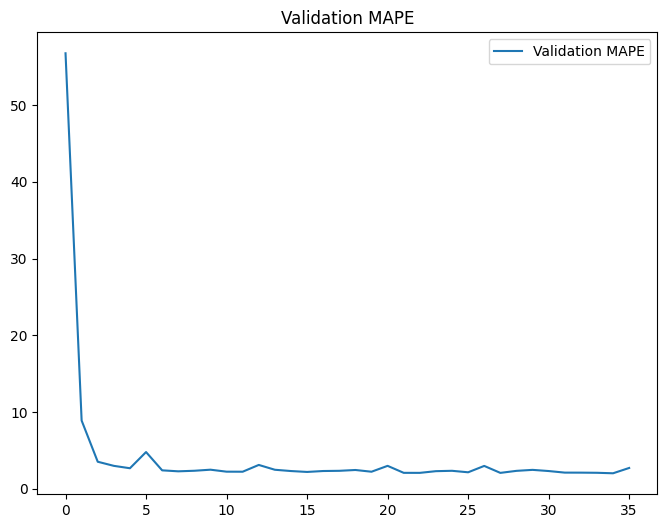

In [ ]:
model_fnn_w7h1_preds_inv, model_fnn_w7h1_res = fit_eval(model_fnn, horizon=1, window=7)
model_fnn_w7h1_res

#### FNN - Window Size 7, Horizon 7

Restoring model weights from the end of the best epoch: 28.
Epoch 36: early stopping

--------------------
Evaluating model on test data...
[0.017425330355763435, 0.017425330355763435, 0.0007736554252915084, 4.1476731300354]
22/22 [==============================] - 0s 764us/step


{'mae': 1270.4005, 'mse': 4112131.5, 'rmse': 1270.4005, 'mape': 4.1195874}

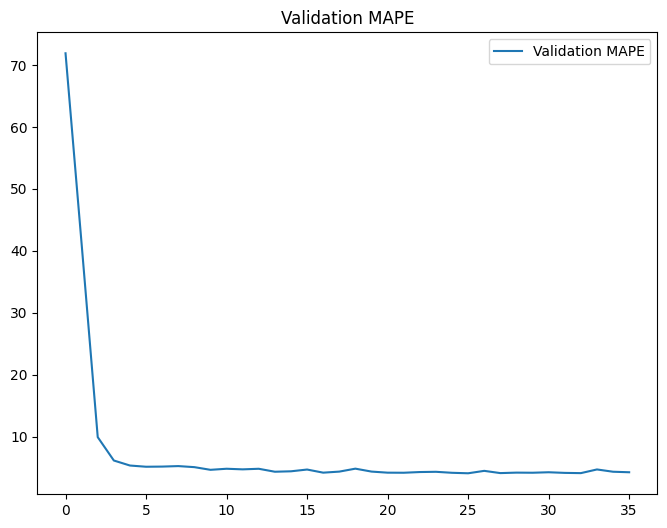

In [ ]:
model_fnn_w7h7_preds_inv, model_fnn_w7h7_res = fit_eval(model_fnn, horizon=7, window=7)
model_fnn_w7h7_res

#### FNN - Window Size 30, Horizon 1

Restoring model weights from the end of the best epoch: 16.
Epoch 24: early stopping

--------------------
Evaluating model on test data...
[0.010638665407896042, 0.010638665407896042, 0.0002670629182830453, 2.567094564437866]
22/22 [==============================] - 0s 698us/step


{'mae': 775.6161, 'mse': 1419492.2, 'rmse': 775.6161, 'mape': 2.549563}

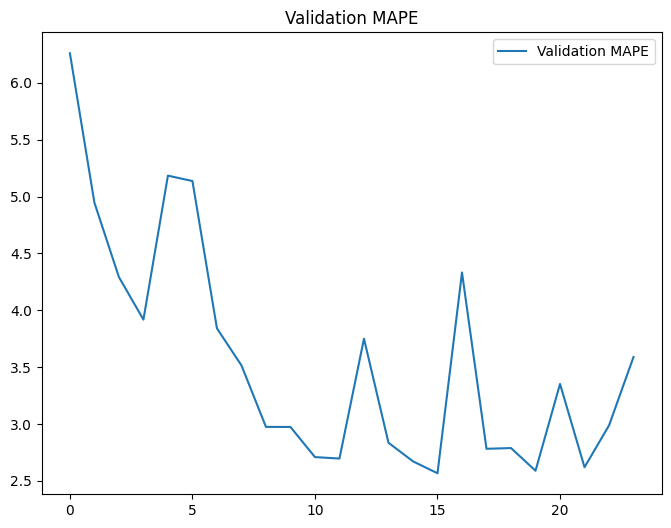

In [ ]:
model_fnn_w30h1_preds_inv, model_fnn_w30h1_res = fit_eval(model_fnn, horizon=1, window=30)
model_fnn_w30h1_res

#### FNN - Window Size 30, Horizon 7

Restoring model weights from the end of the best epoch: 40.
Epoch 48: early stopping

--------------------
Evaluating model on test data...
[0.017343761399388313, 0.017343761399388313, 0.000761401082854718, 4.11614465713501]
22/22 [==============================] - 0s 737us/step


{'mae': 1264.4539, 'mse': 4046997.2, 'rmse': 1264.4539, 'mape': 4.088362}

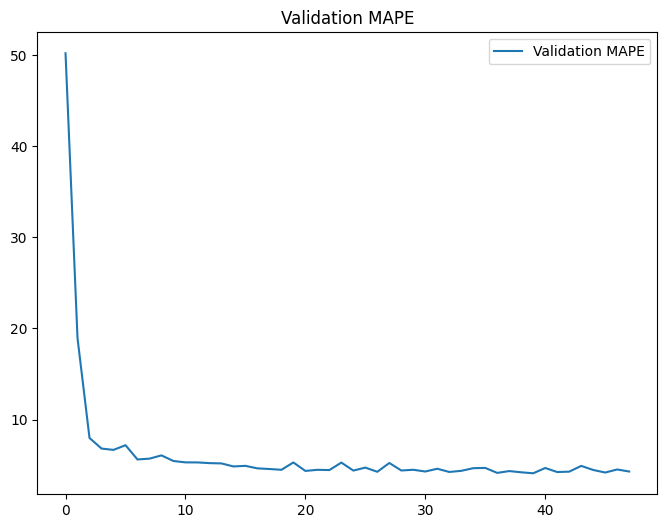

In [ ]:
model_fnn_w30h7_preds_inv, model_fnn_w30h7_res = fit_eval(model_fnn, horizon=7, window=30)
model_fnn_w30h7_res

#### FNN - Window Size 90, Horizon 1

Restoring model weights from the end of the best epoch: 38.
Epoch 46: early stopping

--------------------
Evaluating model on test data...
[0.013339957222342491, 0.013339957222342491, 0.00041237971163354814, 3.2676703929901123]
22/22 [==============================] - 0s 715us/step


{'mae': 972.55493, 'mse': 2191879.0, 'rmse': 972.55493, 'mape': 3.2449448}

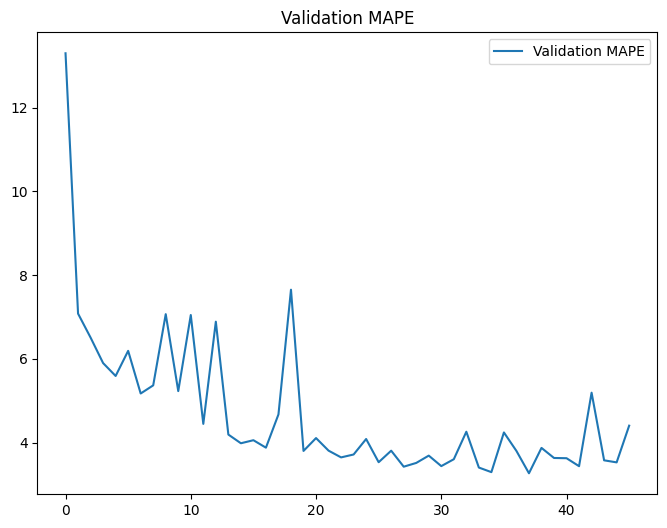

In [ ]:
model_fnn_w90h1_preds_inv, model_fnn_w90h1_res = fit_eval(model_fnn, horizon=1, window=90)
model_fnn_w90h1_res

#### FNN - Window Size 90, Horizon 7

Restoring model weights from the end of the best epoch: 30.
Epoch 38: early stopping

--------------------
Evaluating model on test data...
[0.021633701398968697, 0.021633701398968697, 0.0010168843436986208, 5.2784504890441895]
22/22 [==============================] - 0s 770us/step


{'mae': 1577.2135, 'mse': 5404940.5, 'rmse': 1577.2135, 'mape': 5.2420278}

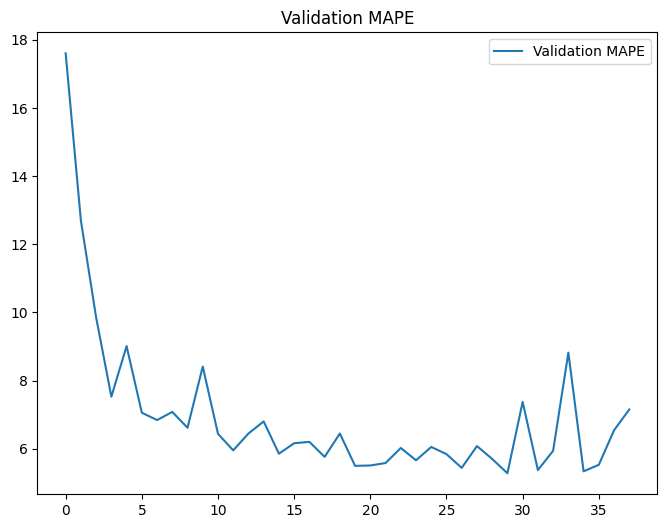

In [ ]:
model_fnn_w90h7_preds_inv, model_fnn_w90h7_res = fit_eval(model_fnn, horizon=7, window=90)
model_fnn_w90h7_res

#### FNN - Window Size 90, Horizon 30

Restoring model weights from the end of the best epoch: 15.
Epoch 23: early stopping

--------------------
Evaluating model on test data...
[0.04219396412372589, 0.04219396412372589, 0.004227600060403347, 10.128080368041992]
22/22 [==============================] - 0s 726us/step


{'mae': 3076.1677, 'mse': 22470524.0, 'rmse': 3076.1677, 'mape': 10.0589075}

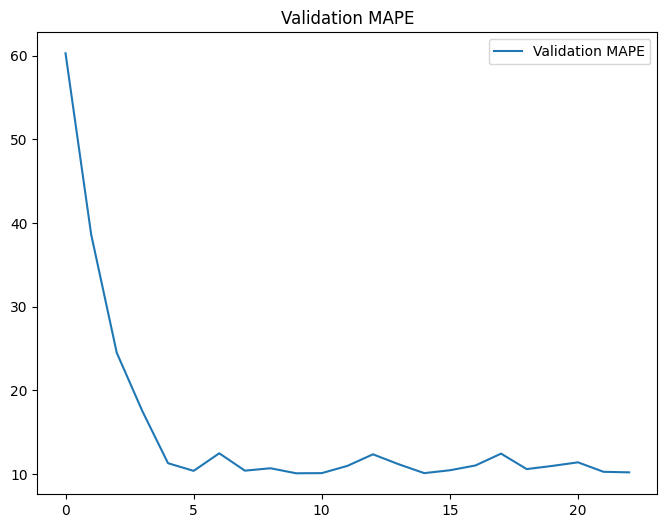

In [ ]:
model_fnn_w90h30_preds_inv, model_fnn_w90h30_res = fit_eval(model_fnn, horizon=30, window=90)
model_fnn_w90h30_res

In [ ]:
# Compile all results together
model_fnn_res = {
    "W7H1": model_fnn_w7h1_res,
    "W7H7": model_fnn_w7h7_res,
    "W30H1": model_fnn_w30h1_res,
    "W30H7": model_fnn_w30h7_res,
    "W90H1": model_fnn_w90h1_res,
    "W90H7": model_fnn_w90h7_res,
    "W90H30": model_fnn_w90h30_res,
}

In [ ]:
all_res["FNN"] = model_fnn_res

### Conv1D (Convolutional Neural Network)

In [ ]:
model_conv1d = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),
    tf.keras.layers.Conv1D(32, kernel_size=8, padding='same', strides=2),
    tf.keras.layers.GlobalMaxPool1D(),
], name="Conv1D")

#### Conv1D - Window - 7 , Horizon - 1

Restoring model weights from the end of the best epoch: 47.
Epoch 55: early stopping

--------------------
Evaluating model on test data...
[0.008051353506743908, 0.008051353506743908, 0.00017892799223773181, 1.8847167491912842]
22/22 [==============================] - 0s 720us/step


{'mae': 586.98706, 'mse': 951037.7, 'rmse': 586.98706, 'mape': 1.8721137}

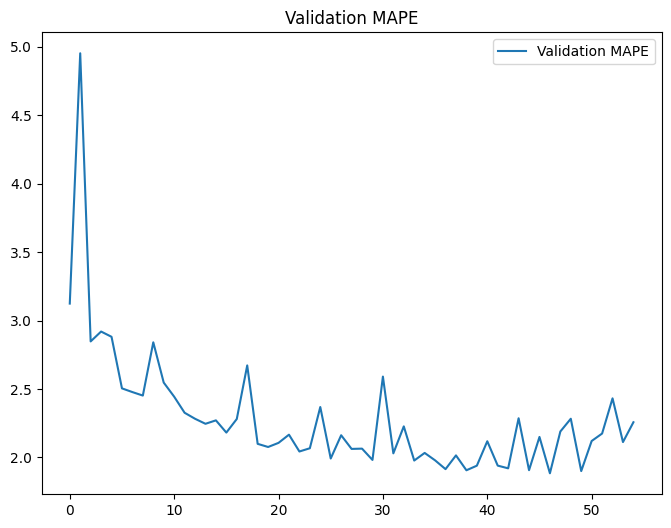

In [ ]:
model_conv1d_w7h1_preds_inv, model_conv1d_w7h1_res = fit_eval(model_conv1d, window=7, horizon=1)
model_conv1d_w7h1_res

#### Conv1D - Window - 7 , Horizon - 7

Restoring model weights from the end of the best epoch: 72.
Epoch 80: early stopping

--------------------
Evaluating model on test data...
[0.016493070870637894, 0.016493070870637894, 0.0007128165452741086, 3.922210216522217]
22/22 [==============================] - 0s 761us/step


{'mae': 1202.4338, 'mse': 3788761.0, 'rmse': 1202.4338, 'mape': 3.8956804}

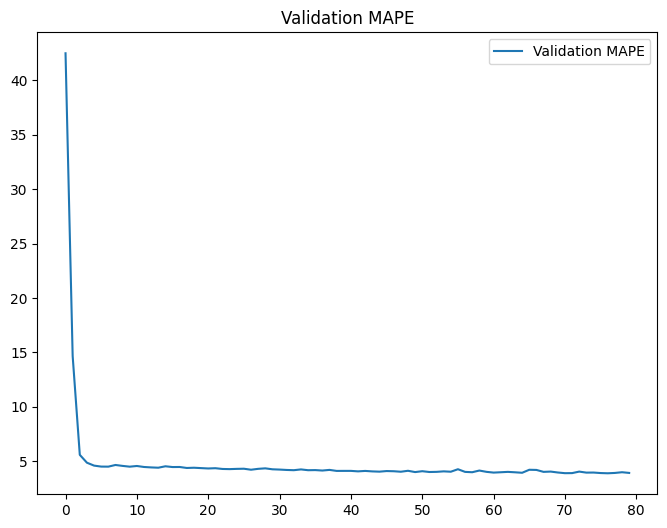

In [ ]:
model_conv1d_w7h7_preds_inv, model_conv1d_w7h7_res = fit_eval(model_conv1d, window=7, horizon=7)
model_conv1d_w7h7_res

#### Conv1D - Window - 30, Horizon - 1

Restoring model weights from the end of the best epoch: 53.
Epoch 61: early stopping

--------------------
Evaluating model on test data...
[0.008479107171297073, 0.008479107171297073, 0.00018992280820384622, 1.9857360124588013]
22/22 [==============================] - 0s 886us/step


{'mae': 618.1727, 'mse': 1009477.3, 'rmse': 618.1727, 'mape': 1.972495}

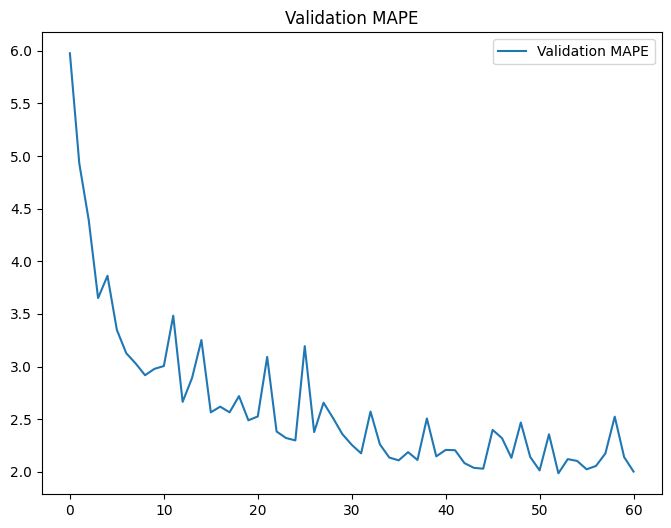

In [ ]:
model_conv1d_w30h1_preds_inv, model_conv1d_w30h1_res = fit_eval(model_conv1d, window=30, horizon=1)
model_conv1d_w30h1_res

#### Conv1D - Window - 30 Horizon - 7

Restoring model weights from the end of the best epoch: 72.
Epoch 80: early stopping

--------------------
Evaluating model on test data...
[0.01707294210791588, 0.01707294210791588, 0.0007441260968334973, 4.066418647766113]
22/22 [==============================] - 0s 833us/step


{'mae': 1244.7096, 'mse': 3955176.5, 'rmse': 1244.7096, 'mape': 4.03889}

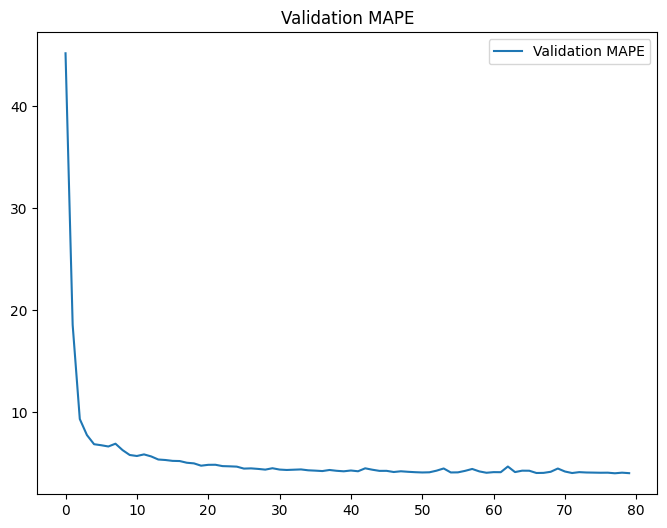

In [ ]:
model_conv1d_w30h7_preds_inv, model_conv1d_w30h7_res = fit_eval(model_conv1d, window=30, horizon=7)
model_conv1d_w30h7_res

#### Conv1D - Window - 90 Horizon - 1

Restoring model weights from the end of the best epoch: 53.
Epoch 61: early stopping

--------------------
Evaluating model on test data...
[0.008621325716376305, 0.008621325716376305, 0.0002062697894871235, 2.036534547805786]
22/22 [==============================] - 0s 888us/step


{'mae': 628.5411, 'mse': 1096364.8, 'rmse': 628.5411, 'mape': 2.0227942}

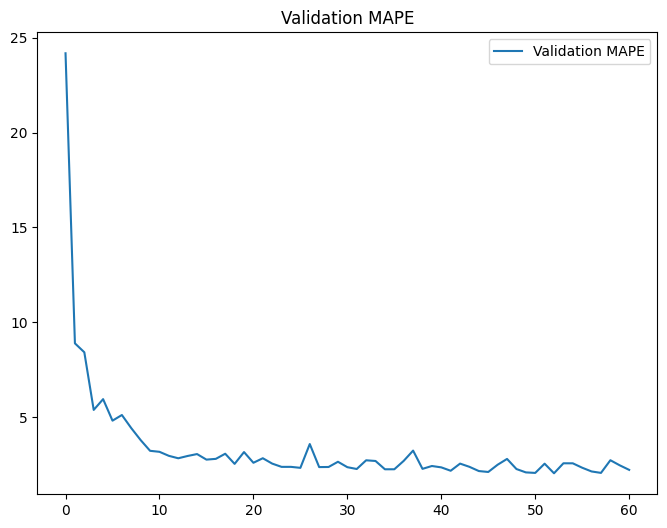

In [ ]:
model_conv1d_w90h1_preds_inv, model_conv1d_w90h1_res = fit_eval(model_conv1d, window=90, horizon=1)
model_conv1d_w90h1_res

#### Conv1D - Window - 90 Horzion - 7

Restoring model weights from the end of the best epoch: 72.
Epoch 80: early stopping

--------------------
Evaluating model on test data...
[0.017064539715647697, 0.017064539715647697, 0.0007741526351310313, 4.01263427734375]
22/22 [==============================] - 0s 789us/step


{'mae': 1244.097, 'mse': 4114774.0, 'rmse': 1244.097, 'mape': 3.9856937}

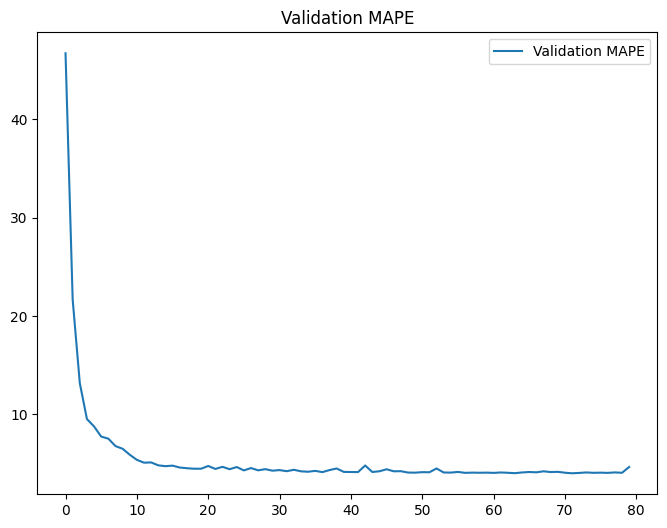

In [ ]:
model_conv1d_w90h7_preds_inv, model_conv1d_w90h7_res = fit_eval(model_conv1d, window=90, horizon=7)
model_conv1d_w90h7_res

#### Conv1D - Window - 90 Horizon - 30

Restoring model weights from the end of the best epoch: 31.
Epoch 39: early stopping

--------------------
Evaluating model on test data...
[0.03571084141731262, 0.03571084141731262, 0.0032336341682821512, 8.642784118652344]
22/22 [==============================] - 0s 716us/step


{'mae': 2603.5132, 'mse': 17187402.0, 'rmse': 2603.5132, 'mape': 8.583257}

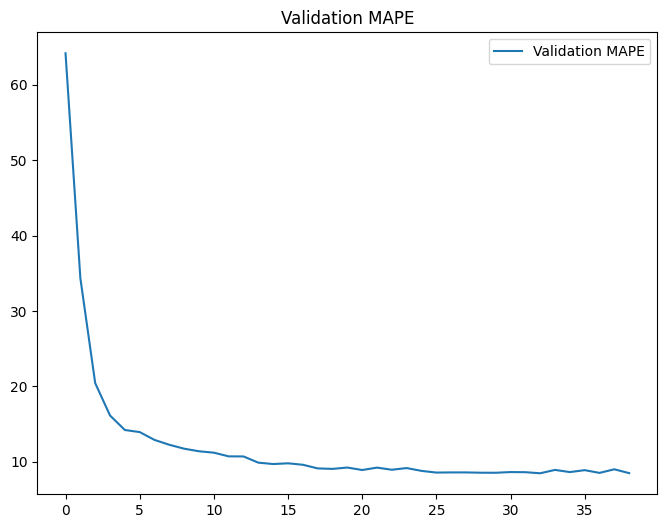

In [ ]:
model_conv1d_w90h30_preds_inv, model_conv1d_w90h30_res = fit_eval(model_conv1d, window=90, horizon=30)
model_conv1d_w90h30_res

In [ ]:
model_conv1d_res = {
    "W7H1": model_conv1d_w7h1_res,
    "W7H7": model_conv1d_w7h7_res,
    "W30H1": model_conv1d_w30h1_res,
    "W30H7": model_conv1d_w30h7_res,
    "W90H1": model_conv1d_w90h1_res,
    "W90H7": model_conv1d_w90h7_res,
    "W90H30": model_conv1d_w90h30_res,
}

In [ ]:
all_res["Conv1D"] = model_conv1d_res

### LSTM (Long Short Term Memory)

In [27]:
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    tf.keras.layers.LSTM(128, activation="linear")
], name="LSTM")

#### LSTM - Window Size 7, Horizon 1

Restoring model weights from the end of the best epoch: 51.
Epoch 59: early stopping

--------------------
Evaluating model on test data...
[0.008357128128409386, 0.008357128128409386, 0.0001905418757814914, 1.9642465114593506]
22/22 [==============================] - 0s 2ms/step
(700,) (700, 1)
(700, 1) (700, 1)


{'mae': 609.27985, 'mse': 1012768.0, 'rmse': 609.27985, 'mape': 1.9510818}

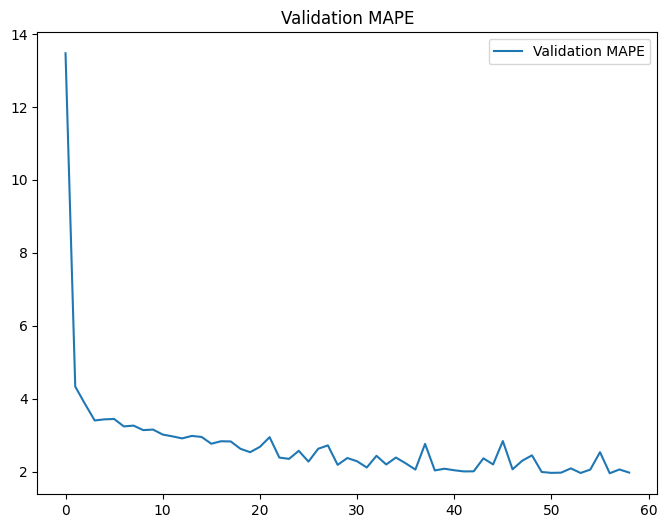

In [28]:
model_lstm_w7h1_preds_inv, model_lstm_w7h1_res = fit_eval(model_lstm, horizon=1, window=7)
model_lstm_w7h1_res

#### LSTM - Window Size 7, Horizon 7

Restoring model weights from the end of the best epoch: 59.
Epoch 67: early stopping

--------------------
Evaluating model on test data...
[0.01683960296213627, 0.01683960296213627, 0.0007273731171153486, 4.018646240234375]
22/22 [==============================] - 0s 2ms/step
(699, 7) (699, 7)
(4893, 1) (4893, 1)


{'mae': 1227.698, 'mse': 3866131.2, 'rmse': 1227.698, 'mape': 3.9913929}

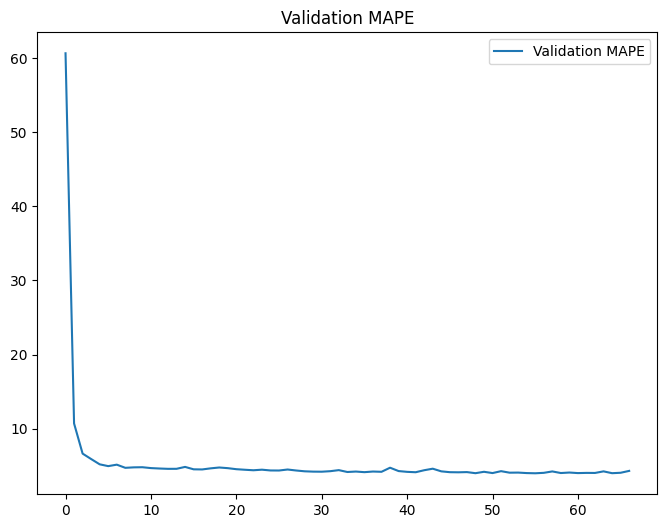

In [29]:
model_lstm_w7h7_preds_inv, model_lstm_w7h7_res = fit_eval(model_lstm, horizon=7, window=7)
model_lstm_w7h7_res

#### LSTM - Window Size 30, Horizon 1

Restoring model weights from the end of the best epoch: 32.
Epoch 40: early stopping

--------------------
Evaluating model on test data...
[0.009978793561458588, 0.009978793561458588, 0.0002527922624722123, 2.394721746444702]
22/22 [==============================] - 0s 2ms/step
(695,) (695, 1)
(695, 1) (695, 1)


{'mae': 727.5078, 'mse': 1343640.9, 'rmse': 727.5078, 'mape': 2.3784816}

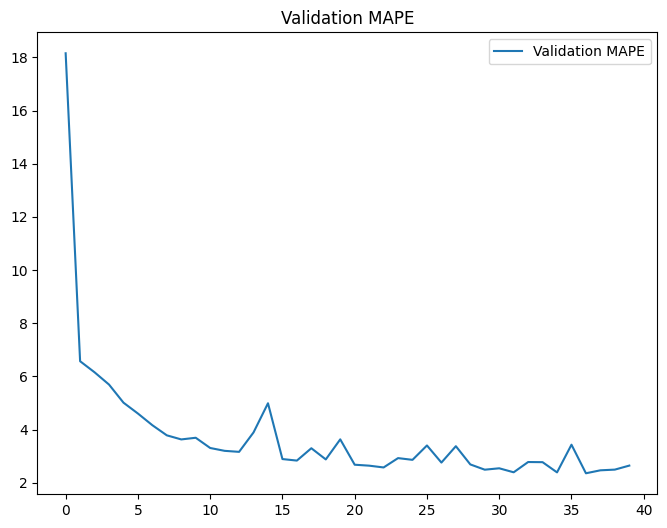

In [30]:
model_lstm_w30h1_preds_inv, model_lstm_w30h1_res = fit_eval(model_lstm, horizon=1, window=30)
model_lstm_w30h1_res

#### LSTM - Window Size 30, Horizon 7

Restoring model weights from the end of the best epoch: 34.
Epoch 42: early stopping

--------------------
Evaluating model on test data...
[0.018274646252393723, 0.018274646252393723, 0.0008267209050245583, 4.370707988739014]
22/22 [==============================] - 0s 3ms/step
(694, 7) (694, 7)
(4858, 1) (4858, 1)


{'mae': 1332.3203, 'mse': 4394184.5, 'rmse': 1332.3203, 'mape': 4.3409877}

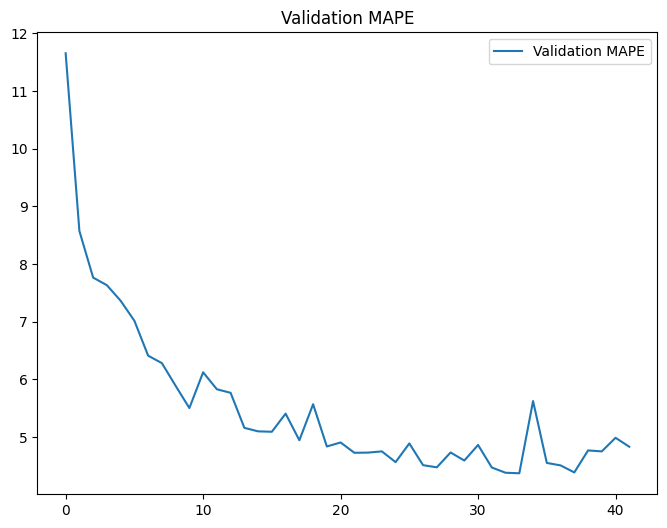

In [31]:
model_lstm_w30h7_preds_inv, model_lstm_w30h7_res = fit_eval(model_lstm, horizon=7, window=30)
model_lstm_w30h7_res

#### LSTM - Window Size 90, Horizon 1

Restoring model weights from the end of the best epoch: 15.
Epoch 23: early stopping

--------------------
Evaluating model on test data...
[0.012899672612547874, 0.012899672612547874, 0.0003782502899412066, 3.1200342178344727]
22/22 [==============================] - 0s 3ms/step
(683,) (683, 1)
(683, 1) (683, 1)


{'mae': 940.4557, 'mse': 2010474.5, 'rmse': 940.4557, 'mape': 3.0987566}

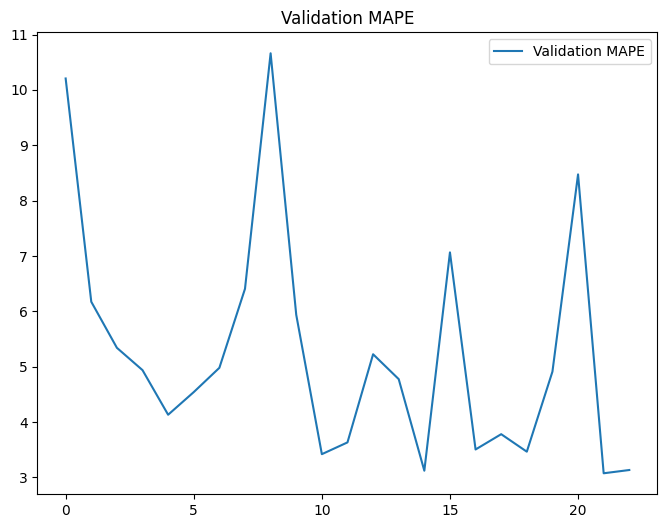

In [32]:
model_lstm_w90h1_preds_inv, model_lstm_w90h1_res = fit_eval(model_lstm, horizon=1, window=90)
model_lstm_w90h1_res

#### LSTM - Window Size 90, Horizon 7

Restoring model weights from the end of the best epoch: 24.
Epoch 32: early stopping

--------------------
Evaluating model on test data...
[0.012091417796909809, 0.012091417796909809, 0.00035354052670300007, 2.889704465866089]
22/22 [==============================] - 0s 2ms/step
(683,) (683, 1)
(683, 1) (683, 1)


{'mae': 881.52954, 'mse': 1879137.2, 'rmse': 881.52954, 'mape': 2.8700469}

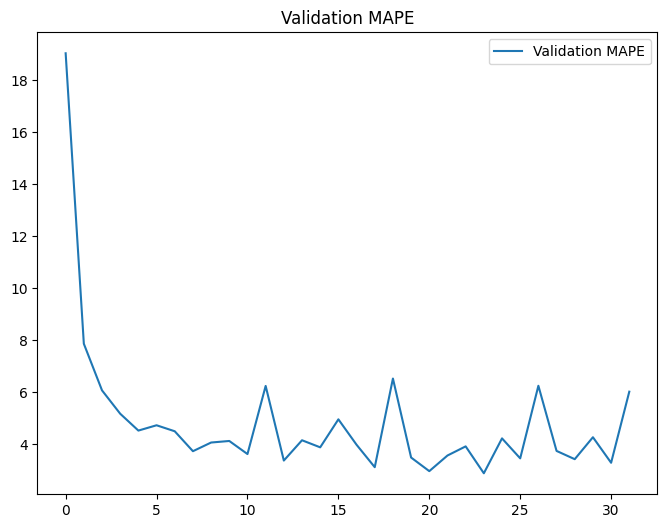

In [33]:
model_lstm_w90h7_preds_inv, model_lstm_w90h7_res = fit_eval(model_lstm, horizon=1, window=90)
model_lstm_w90h7_res

#### LSTM - Window Size 90, Horizon 30

Restoring model weights from the end of the best epoch: 13.
Epoch 21: early stopping

--------------------
Evaluating model on test data...
[0.0418083518743515, 0.0418083518743515, 0.004237797111272812, 10.1417818069458]
22/22 [==============================] - 0s 2ms/step
(678, 30) (678, 30)
(20340, 1) (20340, 1)


{'mae': 3048.0544, 'mse': 22524720.0, 'rmse': 3048.0544, 'mape': 10.07109}

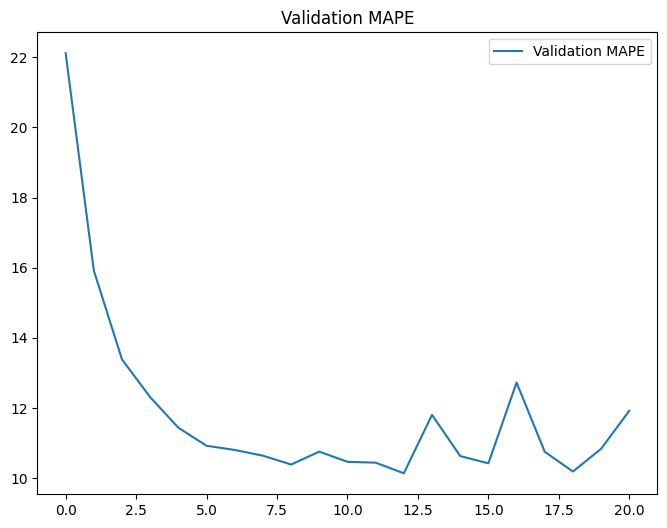

In [34]:
model_lstm_w90h30_preds_inv, model_lstm_w90h30_res = fit_eval(model_lstm, horizon=30, window=90)
model_lstm_w90h30_res

In [35]:
model_lstm_res = {
    "W7H1": model_lstm_w7h1_res,
    "W7H7": model_lstm_w7h7_res,
    "W30H1": model_lstm_w30h1_res,
    "W30H7": model_lstm_w30h7_res,
    "W90H1": model_lstm_w90h1_res,
    "W90H7": model_lstm_w90h7_res,
    "W90H30": model_lstm_w90h30_res,
}

In [36]:
all_res["LSTM"] = model_lstm_res

### Bidirectional LSTM

In [ ]:
model_bi_lstm = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, activation="linear")),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, activation="linear")),
], name="BiLSTM")

#### BiLSTM - Window Size 7, Horizon 1


Restoring model weights from the end of the best epoch: 40.
Epoch 48: early stopping

--------------------
Evaluating model on test data...
[0.00820072740316391, 0.00820072740316391, 0.00018533131515141577, 1.922690987586975]
22/22 [==============================] - 0s 1ms/step


{'mae': 597.87726, 'mse': 985072.75, 'rmse': 597.87726, 'mape': 1.9098141}

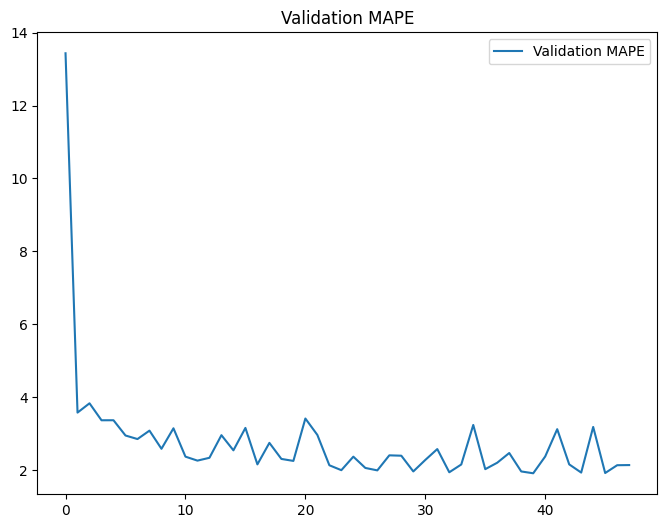

In [ ]:
model_bi_lstm_w7h1_preds_inv, model_bi_lstm_w7h1_res = fit_eval(model_bi_lstm, horizon=1, window=7)
model_bi_lstm_w7h1_res

#### BiLSTM - Window Size 7, Horizon 7

Restoring model weights from the end of the best epoch: 38.
Epoch 46: early stopping

--------------------
Evaluating model on test data...
[0.016759242862462997, 0.016759242862462997, 0.0007389681413769722, 3.9650373458862305]
22/22 [==============================] - 0s 1ms/step


{'mae': 1221.8391, 'mse': 3927762.2, 'rmse': 1221.8391, 'mape': 3.9383252}

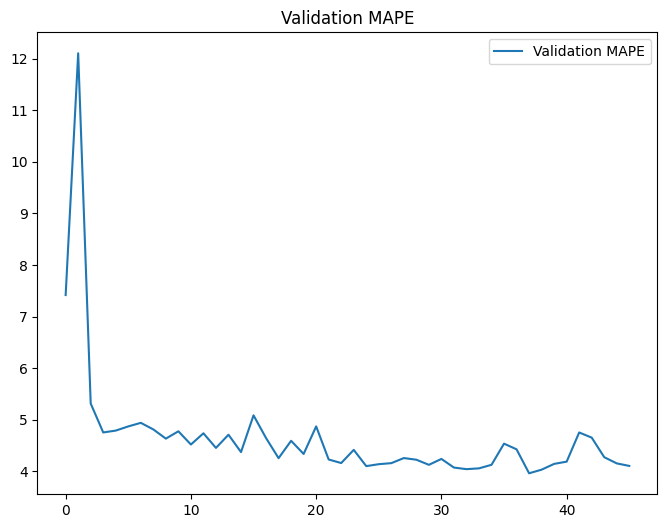

In [ ]:
model_bi_lstm_w7h7_preds_inv, model_bi_lstm_w7h7_res = fit_eval(model_bi_lstm, horizon=7, window=7)
model_bi_lstm_w7h7_res

#### BiLSTM - Window Size 30, Horizon 1

Restoring model weights from the end of the best epoch: 31.
Epoch 39: early stopping

--------------------
Evaluating model on test data...
[0.009021150879561901, 0.009021150879561901, 0.00020968909666407853, 2.1580634117126465]
22/22 [==============================] - 0s 1ms/step


{'mae': 657.69055, 'mse': 1114539.0, 'rmse': 657.69055, 'mape': 2.1434772}

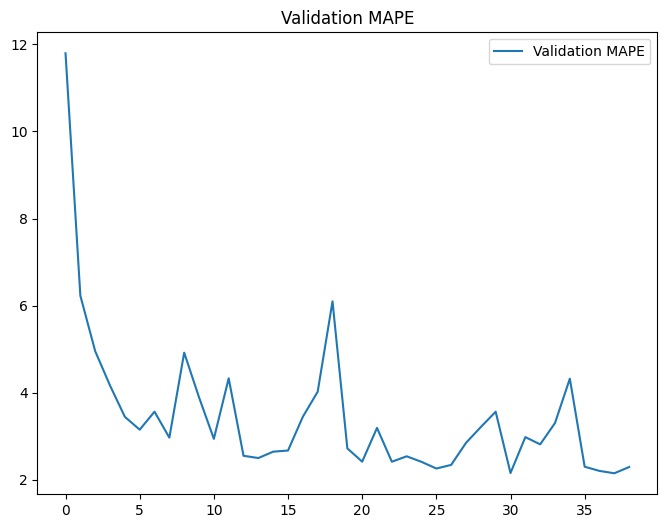

In [ ]:
model_bi_lstm_w30h1_preds_inv, model_bi_lstm_w30h1_res = fit_eval(model_bi_lstm, horizon=1, window=30)
model_bi_lstm_w30h1_res

#### BiLSTM - Window Size 30, Horizon 7

Restoring model weights from the end of the best epoch: 33.
Epoch 41: early stopping

--------------------
Evaluating model on test data...
[0.01750962994992733, 0.01750962994992733, 0.0007912292494438589, 4.132775783538818]
22/22 [==============================] - 0s 1ms/step


{'mae': 1276.5465, 'mse': 4205539.0, 'rmse': 1276.5465, 'mape': 4.104936}

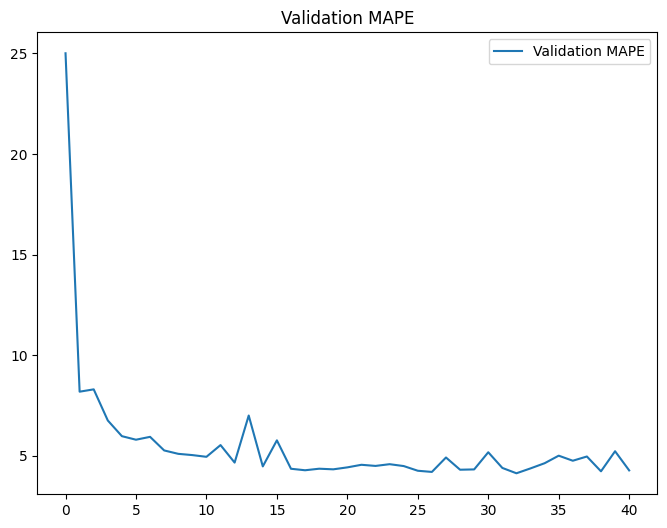

In [ ]:
model_bi_lstm_w30h7_preds_inv, model_bi_lstm_w30h7_res = fit_eval(model_bi_lstm, horizon=7, window=30)
model_bi_lstm_w30h7_res

#### BiLSTM - Window Size 90, Horizon 1

Restoring model weights from the end of the best epoch: 22.
Epoch 30: early stopping

--------------------
Evaluating model on test data...
[0.01190344151109457, 0.01190344151109457, 0.00034786894684657454, 2.8029658794403076]
22/22 [==============================] - 0s 2ms/step


{'mae': 867.8252, 'mse': 1848992.2, 'rmse': 867.8252, 'mape': 2.7840803}

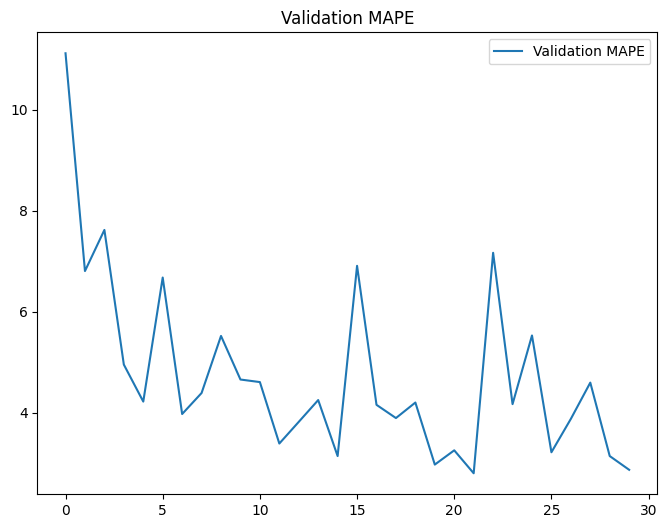

In [ ]:
model_bi_lstm_w90h1_preds_inv, model_bi_lstm_w90h1_res = fit_eval(model_bi_lstm, horizon=1, window=90)
model_bi_lstm_w90h1_res

#### BiLSTM - Window Size 90, Horizon 7

Restoring model weights from the end of the best epoch: 21.
Epoch 29: early stopping

--------------------
Evaluating model on test data...
[0.01977553963661194, 0.01977553963661194, 0.000953514885623008, 4.721593379974365]
22/22 [==============================] - 0s 1ms/step


{'mae': 1441.7433, 'mse': 5068119.5, 'rmse': 1441.7433, 'mape': 4.6894403}

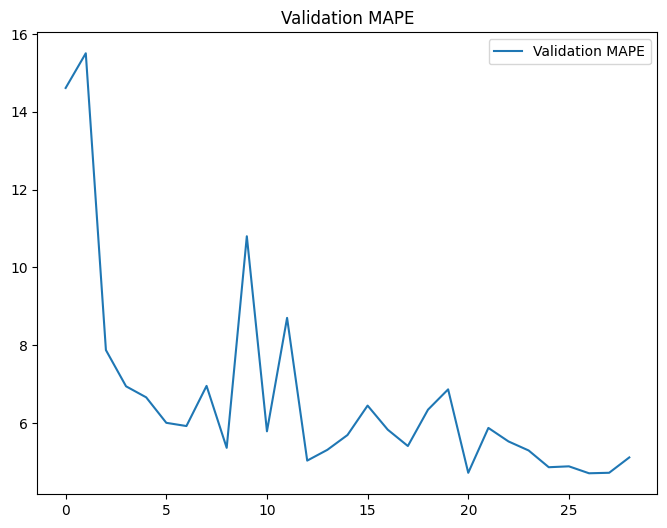

In [ ]:
model_bi_lstm_w90h7_preds_inv, model_bi_lstm_w90h7_res = fit_eval(model_bi_lstm, horizon=7, window=90)
model_bi_lstm_w90h7_res

#### BiLSTM - Window Size 90, Horizon 30

Restoring model weights from the end of the best epoch: 10.
Epoch 18: early stopping

--------------------
Evaluating model on test data...
[0.041313622146844864, 0.041313622146844864, 0.004340537823736668, 9.730570793151855]
22/22 [==============================] - 0s 1ms/step


{'mae': 3011.986, 'mse': 23070814.0, 'rmse': 3011.986, 'mape': 9.664297}

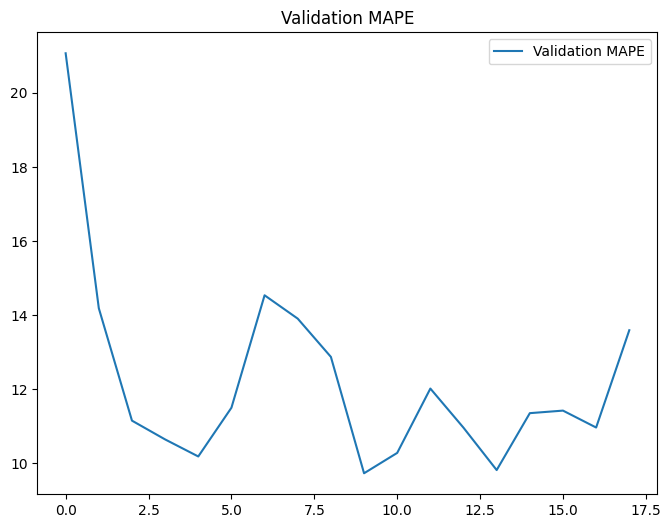

In [ ]:
model_bi_lstm_w90h30_preds_inv, model_bi_lstm_w90h30_res = fit_eval(model_bi_lstm, horizon=30, window=90)
model_bi_lstm_w90h30_res

In [ ]:
model_bi_lstm_res = {
    "W7H1": model_bi_lstm_w7h1_res,
    "W7H7": model_bi_lstm_w7h7_res,
    "W30H1": model_bi_lstm_w30h1_res,
    "W30H7": model_bi_lstm_w30h7_res,
    "W90H1": model_bi_lstm_w90h1_res,
    "W90H7": model_bi_lstm_w90h7_res,
    "W90H30": model_bi_lstm_w90h30_res,
}

In [ ]:
all_res["BiLSTM"] = model_bi_lstm_res

### GRU (Gated Recurrent Unit)

In [ ]:
model_gru = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    tf.keras.layers.GRU(128, activation="linear"),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    tf.keras.layers.GRU(128, activation="linear")
], name="GRU")

#### GRU - Window Size 7, Horizon 1

Restoring model weights from the end of the best epoch: 33.
Epoch 41: early stopping

--------------------
Evaluating model on test data...
[0.00814773328602314, 0.00814773328602314, 0.0001842744677560404, 1.920240879058838]
22/22 [==============================] - 0s 1ms/step


{'mae': 594.0137, 'mse': 979455.25, 'rmse': 594.0137, 'mape': 1.9073231}

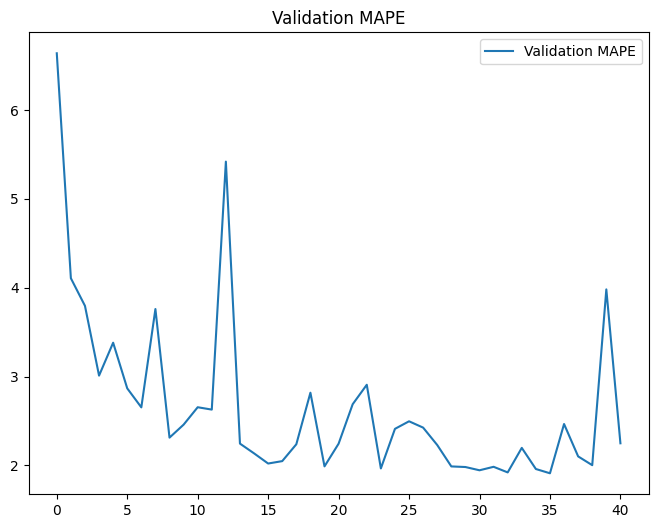

In [ ]:
model_gru_w7h1_preds_inv, model_gru_w7h1_res = fit_eval(model_gru, horizon=1, window=7)
model_gru_w7h1_res

#### GRU - Window Size 7, Horizon 7

Restoring model weights from the end of the best epoch: 34.
Epoch 42: early stopping

--------------------
Evaluating model on test data...
[0.01665993221104145, 0.01665993221104145, 0.0007236945093609393, 3.964153528213501]
22/22 [==============================] - 0s 1ms/step


{'mae': 1214.5991, 'mse': 3846579.0, 'rmse': 1214.5991, 'mape': 3.937322}

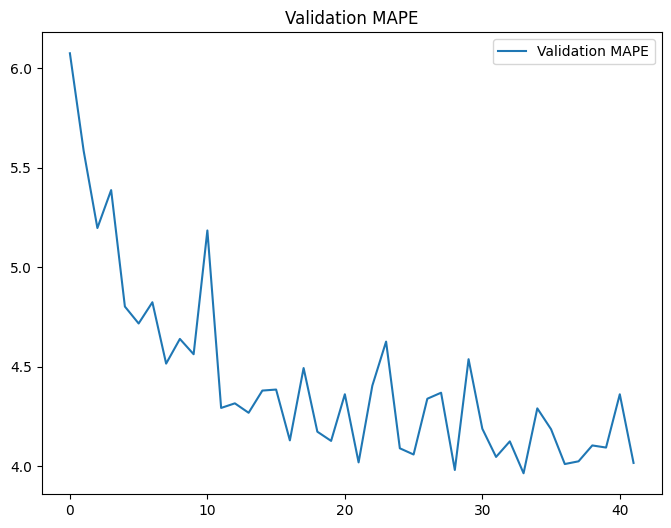

In [ ]:
model_gru_w7h7_preds_inv, model_gru_w7h7_res = fit_eval(model_gru, horizon=7, window=7)
model_gru_w7h7_res

#### GRU - Window Size 30, Horizon 1

Restoring model weights from the end of the best epoch: 33.
Epoch 41: early stopping

--------------------
Evaluating model on test data...
[0.008866208605468273, 0.008866208605468273, 0.00019628538575489074, 2.1259396076202393]
22/22 [==============================] - 0s 1ms/step


{'mae': 646.3944, 'mse': 1043295.56, 'rmse': 646.3944, 'mape': 2.1115239}

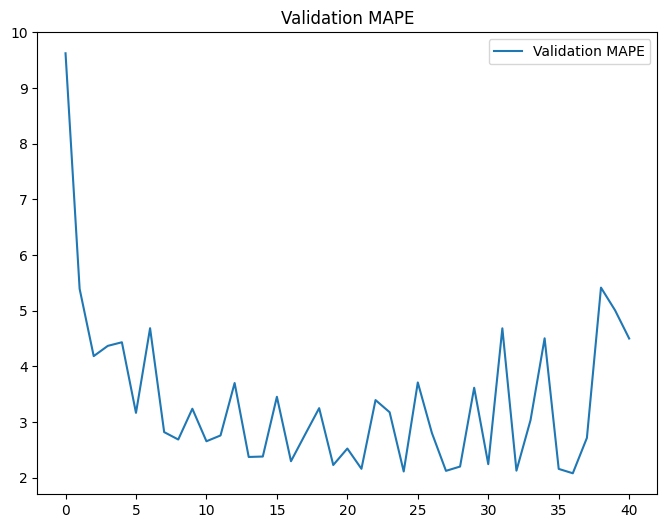

In [ ]:
model_gru_w30h1_preds_inv, model_gru_w30h1_res = fit_eval(model_gru, horizon=1, window=30)
model_gru_w30h1_res

#### GRU - Window Size 30, Horizon 7

Restoring model weights from the end of the best epoch: 23.
Epoch 31: early stopping

--------------------
Evaluating model on test data...
[0.017867160961031914, 0.017867160961031914, 0.0007910282583907247, 4.271101951599121]
22/22 [==============================] - 0s 1ms/step


{'mae': 1302.6123, 'mse': 4204471.0, 'rmse': 1302.6123, 'mape': 4.2421503}

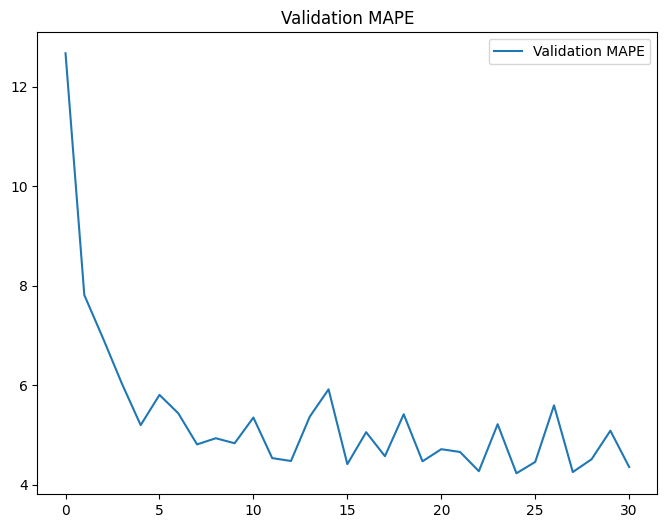

In [ ]:
model_gru_w30h7_preds_inv, model_gru_w30h7_res = fit_eval(model_gru, horizon=7, window=30)
model_gru_w30h7_res

#### GRU - Window Size 90, Horizon 1

Restoring model weights from the end of the best epoch: 21.
Epoch 29: early stopping

--------------------
Evaluating model on test data...
[0.011217254213988781, 0.011217254213988781, 0.0003093196137342602, 2.6710338592529297]
22/22 [==============================] - 0s 1ms/step


{'mae': 817.7984, 'mse': 1644095.0, 'rmse': 817.7984, 'mape': 2.6529796}

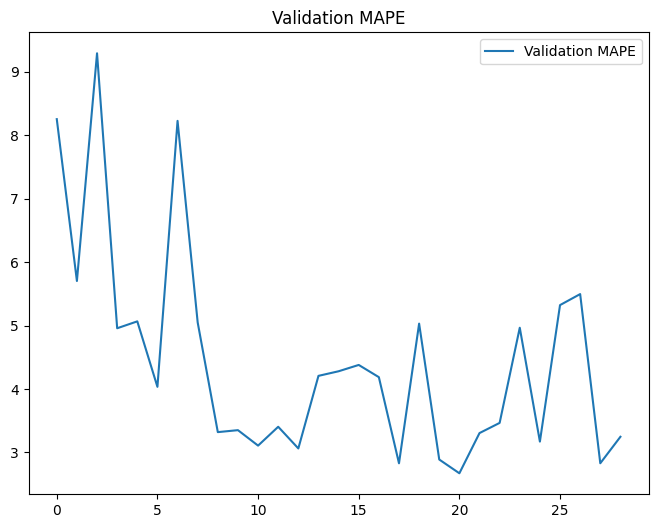

In [ ]:
model_gru_w90h1_preds_inv, model_gru_w90h1_res = fit_eval(model_gru, horizon=1, window=90)
model_gru_w90h1_res

#### GRU - Window Size 90, Horizon 7

Restoring model weights from the end of the best epoch: 22.
Epoch 30: early stopping

--------------------
Evaluating model on test data...
[0.019195212051272392, 0.019195212051272392, 0.000909767288248986, 4.535748481750488]
22/22 [==============================] - 0s 1ms/step


{'mae': 1399.4347, 'mse': 4835592.5, 'rmse': 1399.4347, 'mape': 4.505144}

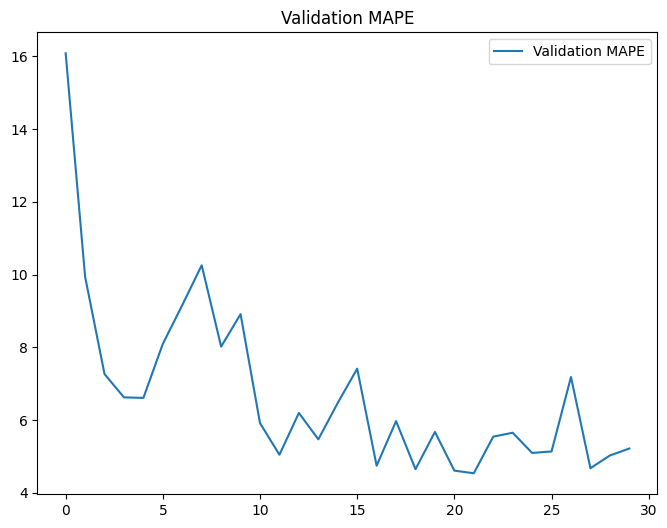

In [ ]:
model_gru_w90h7_preds_inv, model_gru_w90h7_res = fit_eval(model_gru, horizon=7, window=90)
model_gru_w90h7_res

#### GRU - Window Size 90, Horizon 30

Restoring model weights from the end of the best epoch: 19.
Epoch 27: early stopping

--------------------
Evaluating model on test data...
[0.04012439027428627, 0.04012439027428627, 0.004140927921980619, 9.571553230285645]
22/22 [==============================] - 0s 1ms/step


{'mae': 2925.2847, 'mse': 22009848.0, 'rmse': 2925.2847, 'mape': 9.505494}

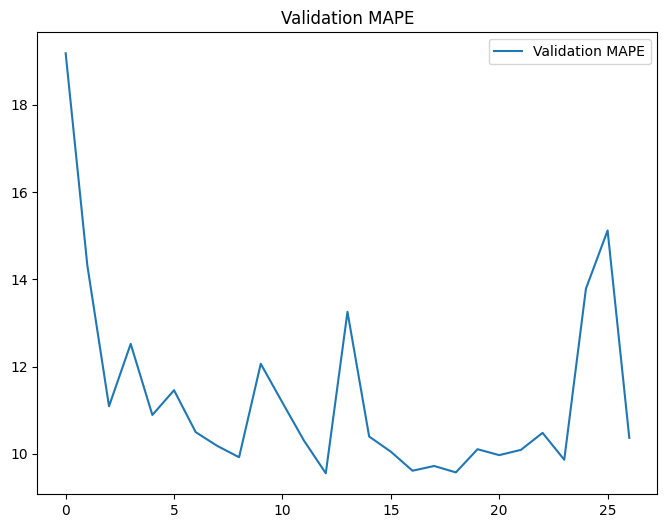

In [ ]:
model_gru_w90h30_preds_inv, model_gru_w90h30_res = fit_eval(model_gru, horizon=30, window=90)
model_gru_w90h30_res

In [ ]:
# Compile all results together
model_gru_res = {
    "W7H1": model_gru_w7h1_res,
    "W7H7": model_gru_w7h7_res,
    "W30H1": model_gru_w30h1_res,
    "W30H7": model_gru_w30h7_res,
    "W90H1": model_gru_w90h1_res,
    "W90H7": model_gru_w90h7_res,
    "W90H30": model_gru_w90h30_res,
}

In [ ]:
all_res["GRU"] = model_gru_res

### Bidirectional GRU (Gated Recurrent Unit)

In [ ]:
model_bi_gru = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(16, activation="relu"))
], name="BiGRU")


#### BiGRU - Window Size 7, Horizon 1

Restoring model weights from the end of the best epoch: 45.
Epoch 53: early stopping

--------------------
Evaluating model on test data...
[0.009966016747057438, 0.009966016747057438, 0.0002535721578169614, 2.3210225105285645]
22/22 [==============================] - 0s 1ms/step


{'mae': 726.57654, 'mse': 1347786.0, 'rmse': 726.57654, 'mape': 2.3055203}

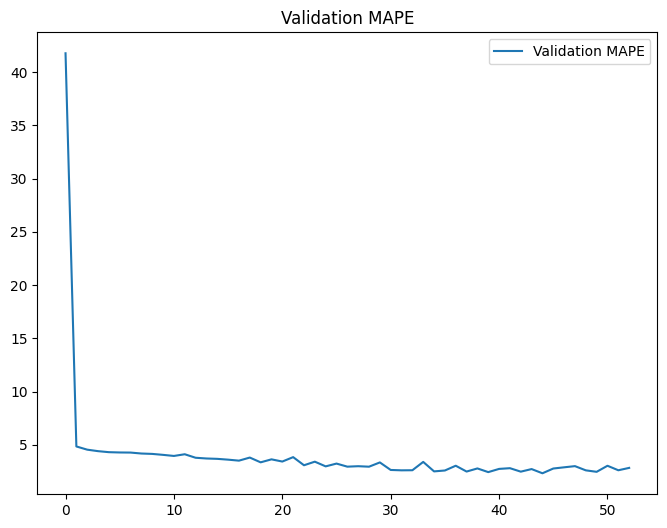

In [ ]:
model_bi_gru_w7h1_preds_inv, model_bi_gru_w7h1_res = fit_eval(model_bi_gru, horizon=1, window=7)
model_bi_gru_w7h1_res

#### BiGRU - Window Size 7, Horizon 7


--------------------
Evaluating model on test data...
[0.018755802884697914, 0.018755802884697914, 0.0008151417132467031, 4.536282062530518]
22/22 [==============================] - 0s 892us/step


{'mae': 1367.3993, 'mse': 4332639.0, 'rmse': 1367.3993, 'mape': 4.505333}

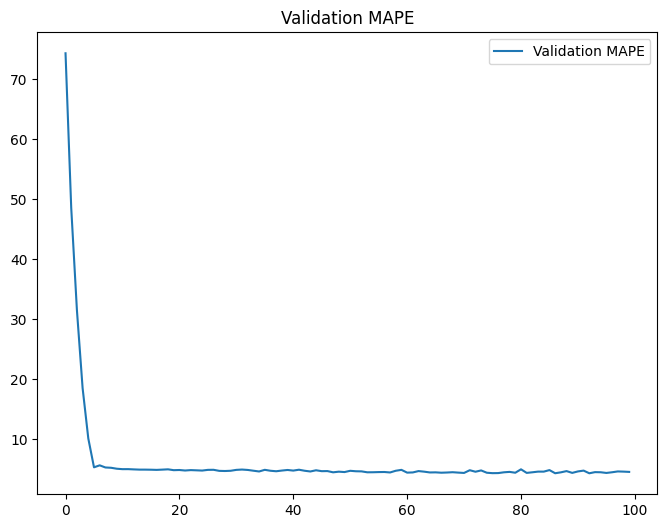

In [ ]:
model_bi_gru_w7h7_preds_inv, model_bi_gru_w7h7_res = fit_eval(model_bi_gru, horizon=7, window=7)
model_bi_gru_w7h7_res

#### BiGRU - Window Size 30, Horizon 1

Restoring model weights from the end of the best epoch: 65.
Epoch 73: early stopping

--------------------
Evaluating model on test data...
[0.009797714650630951, 0.009797714650630951, 0.00023801822680979967, 2.307405948638916]
22/22 [==============================] - 0s 864us/step


{'mae': 714.3063, 'mse': 1265113.9, 'rmse': 714.3063, 'mape': 2.2918413}

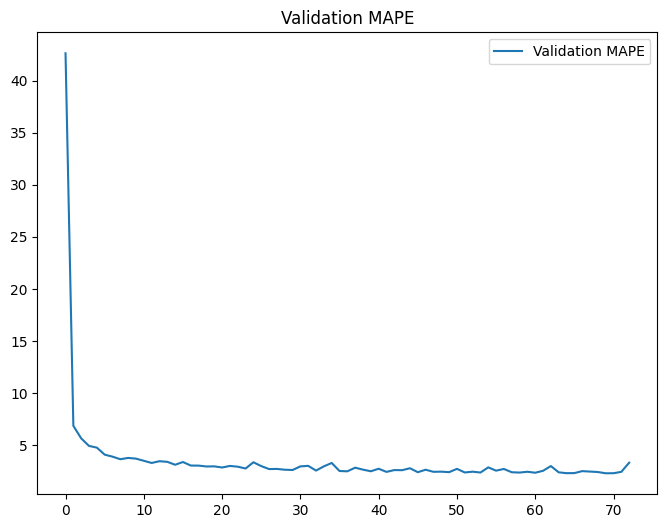

In [ ]:
model_bi_gru_w30h1_preds_inv, model_bi_gru_w30h1_res = fit_eval(model_bi_gru, horizon=1, window=30)
model_bi_gru_w30h1_res

#### BiGRU - Window Size 30, Horizon 7

Restoring model weights from the end of the best epoch: 39.
Epoch 47: early stopping

--------------------
Evaluating model on test data...
[0.019743360579013824, 0.019743360579013824, 0.0008888925658538938, 4.808778285980225]
22/22 [==============================] - 0s 876us/step


{'mae': 1439.3975, 'mse': 4724639.5, 'rmse': 1439.3975, 'mape': 4.7756076}

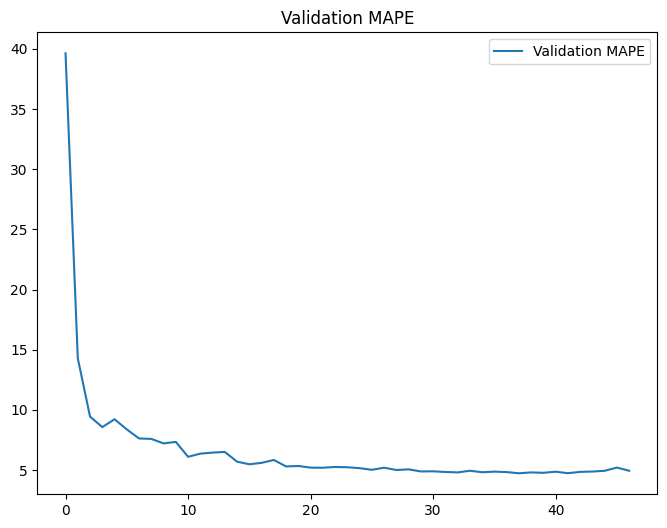

In [ ]:
model_bi_gru_w30h7_preds_inv, model_bi_gru_w30h7_res = fit_eval(model_bi_gru, horizon=7, window=30)
model_bi_gru_w30h7_res

#### BiGRU - Window Size 90, Horizon 1

Restoring model weights from the end of the best epoch: 41.
Epoch 49: early stopping

--------------------
Evaluating model on test data...
[0.012106389738619328, 0.012106389738619328, 0.00034534966107457876, 2.9371299743652344]
22/22 [==============================] - 0s 911us/step


{'mae': 882.6213, 'mse': 1835601.8, 'rmse': 882.6213, 'mape': 2.916818}

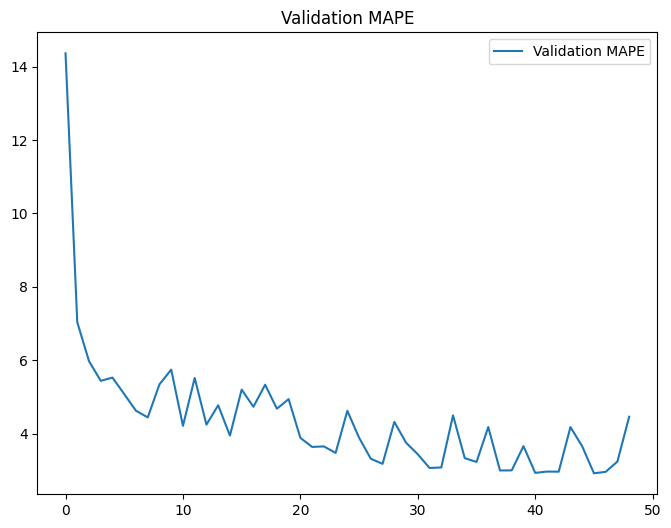

In [ ]:
model_bi_gru_w90h1_preds_inv, model_bi_gru_w90h1_res = fit_eval(model_bi_gru, horizon=1, window=90)
model_bi_gru_w90h1_res

#### BiGRU - Window Size 90, Horizon 7

Restoring model weights from the end of the best epoch: 29.
Epoch 37: early stopping

--------------------
Evaluating model on test data...
[0.02207508310675621, 0.02207508310675621, 0.001127092051319778, 5.303252696990967]
22/22 [==============================] - 0s 844us/step


{'mae': 1609.3926, 'mse': 5990717.0, 'rmse': 1609.3926, 'mape': 5.2668824}

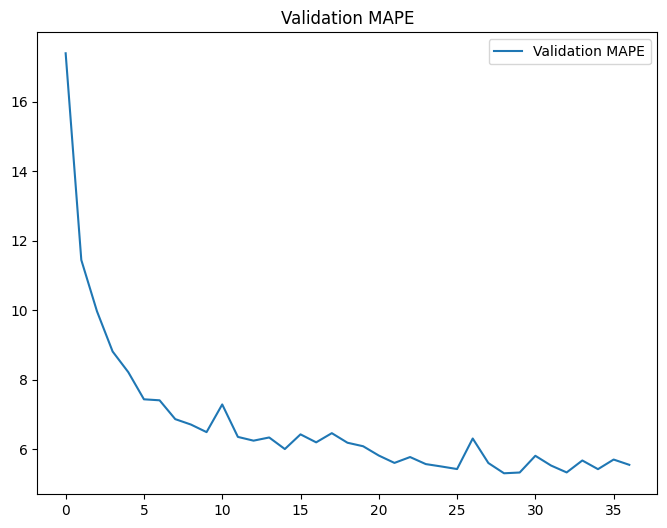

In [ ]:
model_bi_gru_w90h7_preds_inv, model_bi_gru_w90h7_res = fit_eval(model_bi_gru, horizon=7, window=90)
model_bi_gru_w90h7_res

#### BiGRU - Window Size 90, Horizon 30


Restoring model weights from the end of the best epoch: 56.
Epoch 64: early stopping

--------------------
Evaluating model on test data...
[0.03763887658715248, 0.03763887658715248, 0.003573467256501317, 8.928236961364746]
22/22 [==============================] - 0s 841us/step


{'mae': 2744.0776, 'mse': 18993682.0, 'rmse': 2744.0776, 'mape': 8.867612}

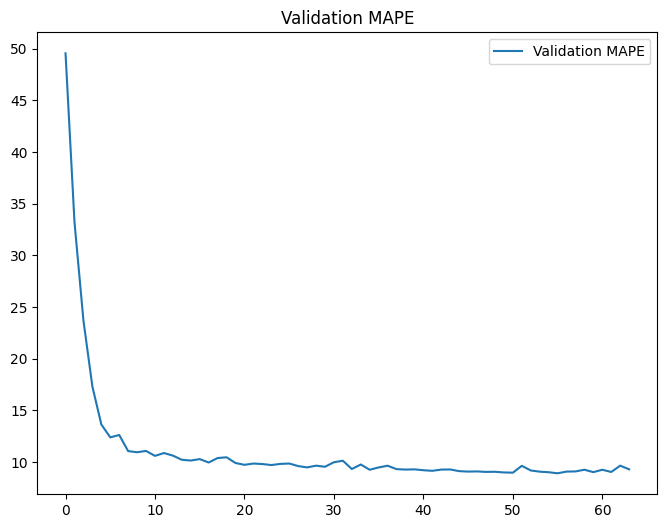

In [ ]:
model_bi_gru_w90h30_preds_inv, model_bi_gru_w90h30_res = fit_eval(model_bi_gru, horizon=30, window=90)
model_bi_gru_w90h30_res

In [ ]:
# Compile all results together
model_bi_gru_res = {
    "W7H1": model_bi_gru_w7h1_res,
    "W7H7": model_bi_gru_w7h7_res,
    "W30H1": model_bi_gru_w30h1_res,
    "W30H7": model_bi_gru_w30h7_res,
    "W90H1": model_bi_gru_w90h1_res,
    "W90H7": model_bi_gru_w90h7_res,
    "W90H30": model_bi_gru_w90h30_res,
}

In [ ]:
all_res["BiGRU"] = model_bi_gru_res

## Evaluating Models

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(pd.DataFrame.from_dict({(i, j): all_res[i][j]
                                  for i in all_res.keys()
                                  for j in all_res[i].keys()},
                                 orient='columns').transpose())

                       mae           mse         rmse       mape
FNN    W7H1     649.203369  1.066386e+06   649.203369   2.075824
       W7H7    1270.400513  4.112132e+06  1270.400513   4.119587
       W30H1    775.616089  1.419492e+06   775.616089   2.549563
       W30H7   1264.453857  4.046997e+06  1264.453857   4.088362
       W90H1    972.554932  2.191879e+06   972.554932   3.244945
       W90H7   1577.213501  5.404940e+06  1577.213501   5.242028
       W90H30  3076.167725  2.247052e+07  3076.167725  10.058908
Conv1D W7H1     586.987061  9.510377e+05   586.987061   1.872114
       W7H7    1202.433838  3.788761e+06  1202.433838   3.895680
       W30H1    618.172729  1.009477e+06   618.172729   1.972495
       W30H7   1244.709595  3.955176e+06  1244.709595   4.038890
       W90H1    628.541077  1.096365e+06   628.541077   2.022794
       W90H7   1244.097046  4.114774e+06  1244.097046   3.985694
       W90H30  2603.513184  1.718740e+07  2603.513184   8.583257
LSTM   W7H1     661.59845

In [ ]:
def plot_grouped(metric="mape", figsize=(10, 7)):
    """
    Plots a grouped bar chart of the evaluation metrics for each model. Each group represents a different window & horizon combination. Metric must be a valid key in the evaluation results dictionary.

    :param metric: str: the evaluation metric to plot, default "mape"
    :param figsize: tuple: the size of the plot, default (10, 7)
    :return: None
    """
    values = [["W7H1"], ["W7H7"], ["W30H1"], ["W30H7"], ["W90H1"], ["W90H7"], ["W90H30"]]
    for k, v in all_res.items():
        values[0].append(v["W7H1"][metric])
        values[1].append(v["W7H7"][metric])
        values[2].append(v["W30H1"][metric])
        values[3].append(v["W30H7"][metric])
        values[4].append(v["W90H1"][metric])
        values[5].append(v["W90H7"][metric])
        values[6].append(v["W90H30"][metric])

    columns = ['Windows & Horizons', *all_res.keys()]
    df = pd.DataFrame(values, columns=columns)

    df.plot(
        x='Windows & Horizons',
        kind='bar',
        stacked=False,
        title=f'{metric.upper()} Values for Different Models and Windows & Horizons',
        figsize=figsize
    )

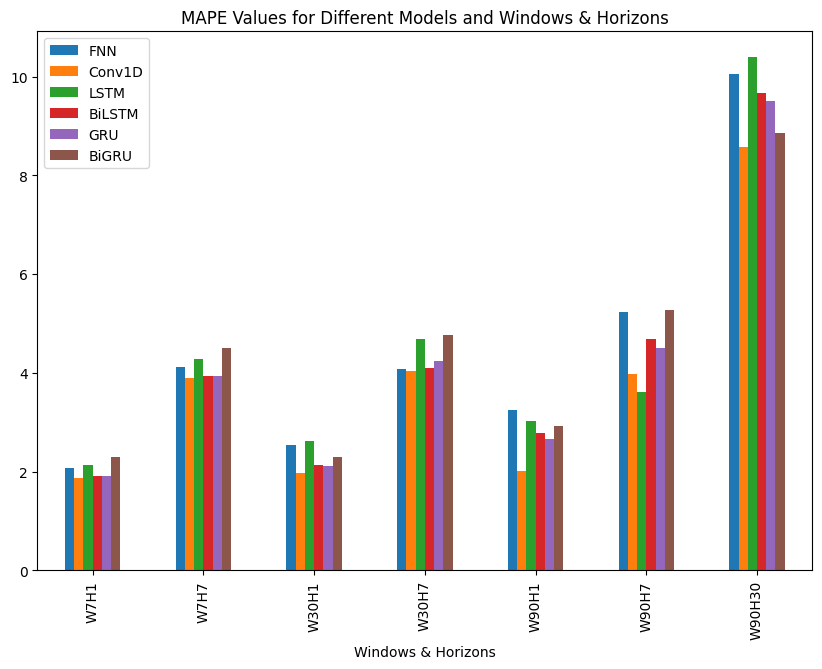

In [ ]:
plot_grouped(metric='mape')

## Multivariate Forecasting

In [ ]:
# Preparing the Dataset
btcc_prices_vol = pd.DataFrame(dataframe[["Close", "Volume"]].values, index=dataframe.index,
                               columns=["Price", "Volume"])
btcc_prices_vol.head()

,Price,Volume
Date,,
2014-09-17,457.334015,21056800.0
2014-09-18,424.440002,34483200.0
2014-09-19,394.795990,37919700.0
2014-09-20,408.903992,36863600.0
2014-09-21,398.821014,26580100.0


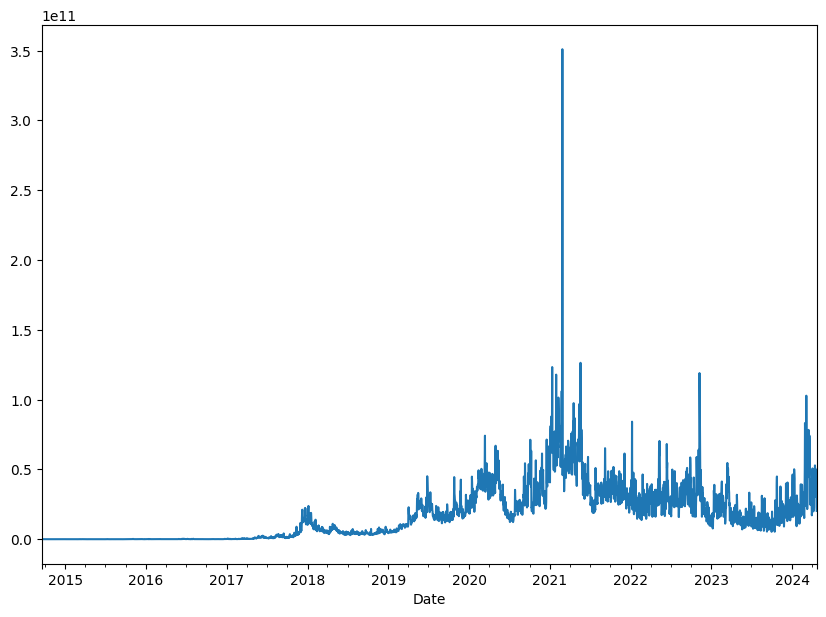

In [ ]:
# Plot the Volume
btcc_prices_vol['Volume'].plot(figsize=(10, 7));

In [ ]:
# If the volume column exceeds 2e11, we will consider it as an outlier
# Tune it down to 2e11
btcc_prices_vol['Volume'] = np.where(btcc_prices_vol['Volume'] > 2e11, 2e11, btcc_prices_vol['Volume'])

In [ ]:
# Normalizing the data
ct = make_column_transformer(
    (MinMaxScaler(), ['Price', 'Volume']),
)
prices_vol_normal = pd.DataFrame(ct.fit_transform(btcc_prices_vol), columns=["Price", "Volume"],
                                 index=btcc_prices_vol.index)

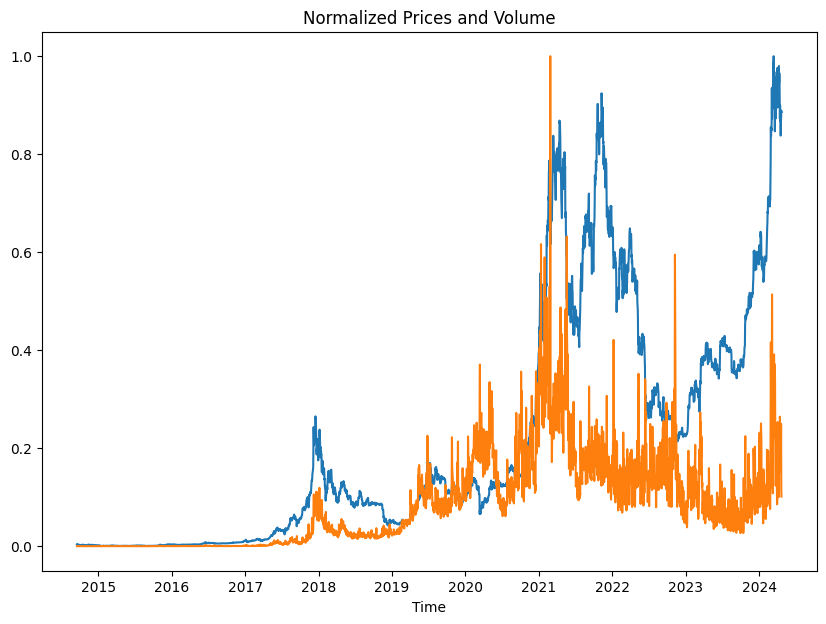

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(prices_vol_normal)
plt.title("Normalized Prices and Volume")
plt.xlabel("Time");

In [ ]:
def make_windows_multivariate(dataframe: pd.DataFrame = prices_vol_normal, window=WINDOW_SIZE, horizon=HORIZON) -> \
        Tuple[List, List]:
    """
    Converts the given Pandas DataFrame into a windowed dataset.
    :param dataframe: Pandas DataFrame: the DataFrame to convert into a windowed dataset, must include 'Price' and 'Volume' columns
    :param window: The window size to use for the dataset, default `WINDOW_SIZE`
    :param horizon: The horizon size to use for the dataset, default `HORIZON`
    :return: A tuple of the windowed data and labels
    """

    btcc_prices_vol_normal_windowed = prices_vol_normal.copy()

    for i in range(window):
        btcc_prices_vol_normal_windowed[f"Price-{i + 1}"] = btcc_prices_vol_normal_windowed["Price"].shift(
            periods=i + 1)
        btcc_prices_vol_normal_windowed[f"Volume-{i + 1}"] = btcc_prices_vol_normal_windowed["Volume"].shift(
            periods=i + 1)

    for i in range(horizon - 1):
        btcc_prices_vol_normal_windowed[f"Price+{i + 1}"] = btcc_prices_vol_normal_windowed["Price"].shift(
            periods=-(i + 1))
        btcc_prices_vol_normal_windowed[f"Volume+{i + 1}"] = btcc_prices_vol_normal_windowed["Volume"].shift(
            periods=-(i + 1))

    btcc_prices_vol_normal_windowed.head(10)

    X = btcc_prices_vol_normal_windowed.dropna().drop(["Price", *[f'Price+{i + 1}' for i in range(horizon - 1)]],
                                                      axis=1).drop(
        ["Volume", *[f'Volume+{i + 1}' for i in range(horizon - 1)]], axis=1).astype(np.float32)
    y = btcc_prices_vol_normal_windowed.dropna()[["Price", *[f'Price+{i + 1}' for i in range(horizon - 1)]]].astype(
        np.float32)

    return X.to_numpy(), y.to_numpy()

In [ ]:
def fit_eval_multivariate(
        model: tf.keras.models.Model,
        horizon=HORIZON,
        window=WINDOW_SIZE,
        epochs=100,
        fit_verbose=0,
) -> Tuple[List, Dict]:
    """
    Creates multivariate sliding windows for the given `WINDOW_SIZE` and `HORIZON`.
    Compiles and fits the model on the data for given number of `epochs`.
    Returns a dictionary of evaluation metrics.

    :param model: tf.keras.models.Model: the model to compile and fit
    :param horizon: int: the number of steps into the future to predict
    :param window: int: the number of timestamps to include in the input window
    :param epochs: int
    :param fit_verbose: int: level of verbosity of the fit method
    :return: a tuple containing the de-normalized predictions and a dictionary of evaluation metrics
    """

    # Clone the model to ensure a fresh copy is used
    model_clone = tf.keras.models.clone_model(model)
    train_windows, test_windows, train_labels, test_labels = make_train_test_splits(
        *make_windows_multivariate(
            window=window,
            horizon=horizon,
        ))

    model_clone.build(input_shape=(None, window * 2))

    model_clone.add(tf.keras.layers.Dense(horizon, activation="linear"))

    model_clone.compile(loss="mae",
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=["mae", "mse", "mape"])

    history = model_clone.fit(
        train_windows,
        train_labels,
        epochs=epochs,
        batch_size=128,
        validation_data=(test_windows, test_labels),
        callbacks=[
            create_model_checkpoint(model_name=model_clone.name + "W" + str(window) + "H" + str(horizon) + "MV"),
            create_early_stopping(patience=8)
        ],
        verbose=fit_verbose,
    )

    pd.DataFrame({"Validation MAPE": history.history['val_mape']}).plot(title="Validation MAPE", figsize=(8, 6))

    print("\n" + "-" * 20 + "\nEvaluating model on test data...")
    print(model_clone.evaluate(test_windows, test_labels, verbose=0))

    model_preds = model_clone.predict(test_windows)
    test_labels_inv = scaler.inverse_transform(tf.reshape(test_labels, shape=(-1, 1)))
    model_preds_inv = scaler.inverse_transform(tf.reshape(model_preds, shape=(-1, 1)))
    model_res = evaluate_pred(y_true=test_labels_inv, y_pred=model_preds_inv)

    return model_preds_inv, model_res


In [ ]:
model_conv1d_w90h30_mv_preds_inv, model_conv1d_w90h30_mv_res = fit_eval_multivariate(
    model_conv1d,
    window=90,
    horizon=30,
    fit_verbose=1,
    epochs=100,
)
model_conv1d_w90h30_mv_res